In [ ]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
#             device = '/gpu:9'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:

import tensorflow as tf
import numpy as np
import h5py
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-08-25 14:42:16.483959: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 14:42:16.518057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 14:42:16.518086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 14:42:16.518114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 14:42:16.524584: I tensorflow/core/platform/cpu_feature_g

In [2]:


# Load HDF5 data
# h5_filename = '/home/da886/ElectronCountingProject/Small Building Blocks/Data Generated/150K_3electronsOnly.h5'#### i used this for training and saved it under weekend steps weights
# with h5py.File(h5_filename, 'r') as f:
#     images = np.array(f['images'][:100000])
#     centers = np.array(f['centers_training'][:100000])
h5_filename = '3-700padded.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'])
    centers = np.array(f['centers_training'])


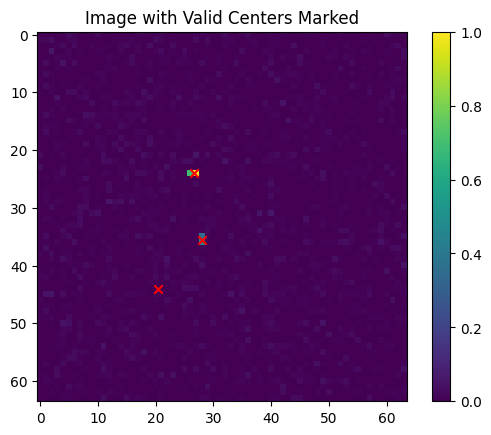

In [7]:
a = np.random.randint(0, len(images))
# a =2
image = images[a]
centerss = centers[a]

# Plot the image with valid centers
plt.imshow(image, )
valid_centers = centerss[centerss[:, 0] == 1]
for center in valid_centers:
    plt.scatter(center[1], center[2], c='red', marker='x')  # Note: center[1] is x and center[2] is y
plt.title('Image with Valid Centers Marked')
plt.colorbar()
plt.show()


In [8]:


# Function to sort centers from top-left to bottom-right
def sort_centers(centers):
    # Sort by y first, then by x
    return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

# Sort the centers for each image
sorted_centers = np.array([sort_centers(image_centers[:, 1:]) for image_centers in centers])


In [29]:
k= np.random.randint(0, len(sorted_centers))
sorted_centers[k]

array([[36.      , 11.      ],
       [45.93286 , 18.059294],
       [32.      , 41.      ]], dtype=float32)

In [5]:

# normalized_images = (images+1e-9)/9.26
normalized_images = (images)/np.max(images)
normalized_centers = sorted_centers /  64
normalized_midpoints =normalized_centers
normalized_midpoints = tf.expand_dims(normalized_midpoints,axis =1)
normalized_midpoints_np = normalized_midpoints.numpy()

2024-08-25 14:36:00.391209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21540 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [6]:
np.max(normalized_images), np.min(normalized_images)

(1.0, 0.0)

In [7]:
np.max(normalized_centers), np.min(normalized_centers)

(0.8586115, 0.0)

In [8]:
# Perform the random split
train_images, val_images, train_midpoints, val_midpoints = train_test_split(
    normalized_images, normalized_midpoints_np, train_size=0.8, random_state=42
)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

In [10]:
train_images.shape,val_images.shape,train_midpoints.shape

((560, 64, 64), (140, 64, 64), (560, 1, 3, 2))

In [11]:
batch_size = 300
train_dataset = train_dataset.shuffle(buffer_size=2000,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)

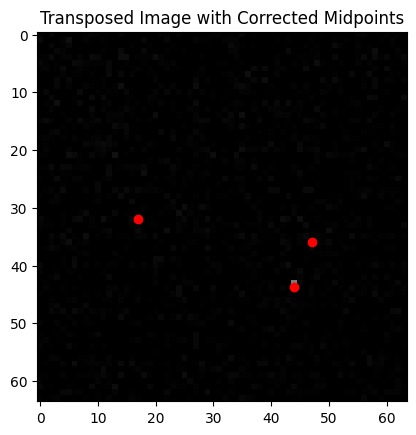

In [12]:

sample_image, sample_midpoints = next(iter(train_dataset))


# Convert TensorFlow tensors to NumPy arrays (if they are tensors)
sample_image = np.array(sample_image[2])
sample_midpoints = np.array(sample_midpoints[2])

# # Transpose the image and correctly swap the midpoints

transposed_image = sample_image.T
transposed_midpoints_corrected = sample_midpoints[:,:, [1, 0]]  # Correctly swap x and y coordinates

# Plot the transposed image with corrected midpoints
plt.imshow(transposed_image, cmap='gray')
plt.scatter(transposed_midpoints_corrected[:,:, 0] * 64, transposed_midpoints_corrected[:,:, 1] * 64, c='red', marker='o')
plt.title('Transposed Image with Corrected Midpoints')
plt.show()


In [ ]:
normalized_midpoints 

In [13]:
from tensorflow.keras import layers


input_shape = (64, 64, 1)
num_classes = 3
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)


# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, x_midpoints_reshape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 



In [12]:
train_outputs = model.predict(train_images)
val_outputs = model.predict(val_images)

2024-08-25 14:33:41.178119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


5/5 [==============================] - 0s 53ms/step


In [14]:
import tensorflow as tf

class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent=3, increment=0.5, update_frequency=10):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss


In [14]:
dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=10)
loss=dynamic_exponent_callback.custom_loss(3)
tl =loss(train_outputs,train_midpoints)
vl = loss(val_outputs,val_midpoints)

tl,vl

(<tf.Tensor: shape=(), dtype=float32, numpy=0.048390154>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05022972>)

In [15]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 200  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

# Define the ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       # Monitor the validation loss
    factor=0.5,               # Factor by which the learning rate will be reduced
    patience=5,               # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                # Verbosity mode, 1: output logs
    mode='min',               # Min mode, as we want to reduce the LR when the monitored quantity stops decreasing
    min_lr=5e-14               # Lower bound on the learning rate
)

In [16]:
# Define and compile your model initially with the initial exponent

dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=10)
model.compile(optimizer=optimizer, loss=dynamic_exponent_callback.custom_loss(3))




In [38]:
# history = model.fit(train_dataset, epochs=1700, validation_data=val_dataset,callbacks=[checkpoint_callback,lr_scheduler])
history = model.fit(train_dataset, epochs=60, validation_data=val_dataset,callbacks=[dynamic_exponent_callback,lr_scheduler])
# history = model_custom.fit(train_dataset, epochs=150, validation_data=val_dataset)

Epoch 1/60


2024-08-25 14:24:11.657162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-25 14:24:12.762753: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7caac314da10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-25 14:24:12.762782: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-25 14:24:12.766799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-25 14:24:12.870321: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 7s 7s/step - loss: 0.0879 - val_loss: 0.0509 - lr: 0.0010
Epoch 2/60
1/1 [==============================] - 0s 38ms/step - loss: 0.1141 - val_loss: 0.0494 - lr: 0.0010
Epoch 3/60
1/1 [==============================] - 0s 45ms/step - loss: 0.0556 - val_loss: 0.0468 - lr: 0.0010
Epoch 4/60
1/1 [==============================] - 0s 47ms/step - loss: 0.0427 - val_loss: 0.0476 - lr: 0.0010
Epoch 5/60
1/1 [==============================] - 0s 43ms/step - loss: 0.0383 - val_loss: 0.0504 - lr: 0.0010
Epoch 6/60
1/1 [==============================] - 0s 43ms/step - loss: 0.0431 - val_loss: 0.0539 - lr: 0.0010
Epoch 7/60
1/1 [==============================] - 0s 46ms/step - loss: 0.0401 - val_loss: 0.0587 - lr: 0.0010
Epoch 8/60
1/1 [==============================] - ETA: 0s - loss: 0.0326
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 48ms/step - loss: 0.0326 - val_loss: 0.0644 - lr: 0.

In [17]:


# Print the available keys in the history
print(history.history.keys())

# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If there are specific losses for x_prob and x_midpoints, extract them
train_loss_x_prob = history.history.get('x_prob_reshape_loss', train_loss)
val_loss_x_prob = history.history.get('val_x_prob_reshape_loss', val_loss)
train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)


# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Plotting x_prob_reshape loss
plt.subplot(1, 2,1)
plt.plot(train_loss_x_prob, label='Train Loss ')
plt.plot(val_loss_x_prob, label='Validation Loss ')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

# # Plotting x_midpoints_reshape loss
# plt.subplot(1, 2, 2)
# plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
# plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss for x_midpoints_reshape')
# plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [18]:
# u =tf.keras.models.load_model("/home/da886/ElectronCountingProject/weekend steps custom loss weights/customlossmodel.keras",safe_mode=False) 
u =tf.keras.models.load_model("/home/m3-learning/Documents/customlossmodel08_21.h5",safe_mode=False)

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 64, 64, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))

train_dataset = train_dataset.batch(200)
inputs,targets = next(iter(train_dataset))
output =model.predict(inputs)

# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(400)
# inputs,targets = next(iter(val_dataset))
# output =model.predict(inputs)

1/1 [==============================] - 0s 143ms/step


In [43]:
h = np.random.randint(0,len(output))
output[h]*64,targets[h]*64

(array([[[ 4.7987914, 28.689018 ],
         [ 9.133763 ,  0.5998378],
         [13.991851 , 29.680254 ]]], dtype=float32),
 <tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
 array([[[ 0.      ,  0.      ],
         [ 0.      ,  0.      ],
         [53.419136, 40.81821 ]]], dtype=float32)>)

In [ ]:
import tensorflow as tf
def custom_loss(y_true, y_pred, exponent=10):
    diff = tf.abs(y_true - y_pred)
    powered_diff = tf.pow(diff, exponent)
    return tf.reduce_mean(powered_diff)

# # r = np.random.randint(0,100)
# tensor1 = tf.constant(targets, dtype=tf.float64)

# tensor2 = tf.constant(output, dtype=tf.float32)


# tensor2 = tf.cast(tensor2, tf.float64)


# mse_loss_fn = custom_mse(tensor1, tensor2)
# mse_loss = mse_loss_fn(tensor1, tensor2)
mse_loss_fn = custom_loss(targets, output, exponent=10)

print("MSE Loss:", mse_loss_fn.numpy())

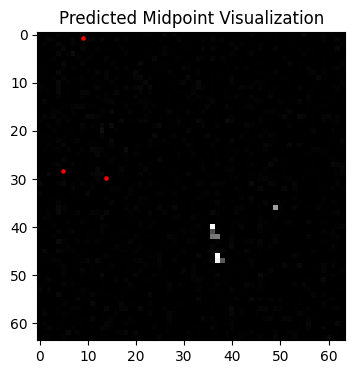

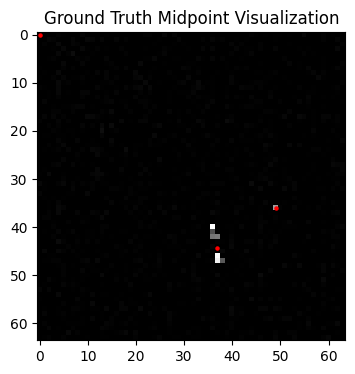

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 200)
# t=5

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*64)
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)
